In [487]:
ls

Loan Prediction Data Story.ipynb  loan_data1.csv
accepted_2007_to_2018Q4.csv*


In [488]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as pp

%matplotlib inline

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

import pymc3 as pm

from IPython import display
from ipywidgets import widgets, interact

In [489]:
import seaborn as sns
from matplotlib import rcParams
sns.set_style("whitegrid")
sns.set_context("poster")
pp.rcParams['figure.figsize'] = (7,7)

In [490]:
loan_data = pd.read_csv('accepted_2007_to_2018Q4.csv')

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [491]:
loan_data.shape

(2260701, 151)

The dataset has 2.26 million rows and 151 features.

In [492]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB


## Goal and Response Variable

Our goal is to predict if the loan applicant, when offered with a loan, will default in the future or not. We will be predicting this using the loan_status column, our response variable.

Let us look at the loan_status feature values and its counts.

In [493]:
loan_data['loan_status'].value_counts(dropna=False)
#dropna=False will display NaNs below

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
NaN                                                         33
Name: loan_status, dtype: int64

The model we build has to predict, for new data, if the loan_status will be Fully Paid or Charged Off. To train the model we only need loans that were fully paid or charged off so we can drop the other loan_status values.

In [494]:
loan_data = loan_data.loc[loan_data['loan_status'].isin(['Fully Paid', 'Charged Off'])]

In [495]:
loan_data.shape

(1345310, 151)

1.3 million rows remain in the data.

In [496]:
loan_data['loan_status'].value_counts()

Fully Paid     1076751
Charged Off     268559
Name: loan_status, dtype: int64

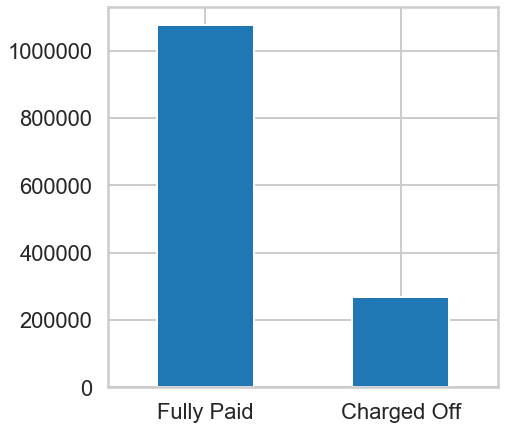

In [497]:
loan_data['loan_status'].value_counts().plot(kind='bar', rot=0)

Let's count these as percentages:

In [498]:
loan_data['loan_status'].value_counts(normalize=True)*100

Fully Paid     80.037389
Charged Off    19.962611
Name: loan_status, dtype: float64

About 80% of the loans were fully paid and 20% were charged off. 

## Data Cleaning and Feature Selection

**In the below step, features that have more than 40% of their data missing will be removed.**

In [499]:
cols_missing_values = loan_data.isna().sum()/len(loan_data)*100
print("Features with more than 40% missing values")
print(cols_missing_values[cols_missing_values > 40].sort_values(ascending=False))

Features with more than 40% missing values
member_id                                     100.000000
next_pymnt_d                                  100.000000
orig_projected_additional_accrued_interest     99.720585
hardship_length                                99.572292
hardship_type                                  99.572292
hardship_reason                                99.572292
hardship_status                                99.572292
deferral_term                                  99.572292
hardship_amount                                99.572292
hardship_start_date                            99.572292
hardship_end_date                              99.572292
payment_plan_start_date                        99.572292
hardship_dpd                                   99.572292
hardship_loan_status                           99.572292
hardship_payoff_balance_amount                 99.572292
hardship_last_payment_amount                   99.572292
sec_app_mths_since_last_major_derog          

In [500]:
percentage_missing_values = (loan_data.isna().sum()/len(loan_data)*100)

In [501]:
drop_features = percentage_missing_values[percentage_missing_values > 40].index

In [502]:
drop_features = list(drop_features)

In [503]:
len(drop_features)

58

In [504]:
loan_data.drop(columns = drop_features, axis=1, inplace=True)

In [505]:
loan_data.shape

(1345310, 93)

**Next we will drop the columns that will not be available in the applicant's application file.**

In [506]:
loan_data.columns

Index(['id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'pymnt_plan', 'url', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
       'last_fico_range_high', 'last_fico_range_low',
       'collections_12_mths_ex_med', 'policy_code', 'application_type',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'acc_open_past_24mths', 'a

Some features will be available to the investor when deciding to fund the loan or not, let's call these features as **known_features**.
Rest of the features - **unknown_features**

In [507]:
known_features = ['id', 'loan_amnt', 'term', 'int_rate','installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'loan_status', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'total_acc', 'initial_list_status', 
       'application_type', 'acc_now_delinq', 'mort_acc', 'pub_rec_bankruptcies']     

In [508]:
unknown_features = ['funded_amnt', 'funded_amnt_inv', 'issue_d', 'pymnt_plan', 'url', 'delinq_2yrs', 
                    'revol_bal', 'revol_util', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 
                    'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 
                    'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d', 
                    'collections_12_mths_ex_med', 'policy_code',  'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 
                    'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 
                    'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 
                    'mo_sin_rcnt_tl', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 
                    'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 
                    'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 
                    'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 
                    'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 
                    'total_il_high_credit_limit', 'hardship_flag', 'disbursement_method', 
                    'debt_settlement_flag', 'last_fico_range_high', 'last_fico_range_low']

In [509]:
print('Number of known features: ', len(known_features))
print('Number of unknown features: ', len(unknown_features))

Number of known features:  30
Number of unknown features:  63


We will now drop the unknown features.

In [510]:
loan_data.drop(columns = unknown_features, axis=1, inplace=True)

In [511]:
loan_data.shape

(1345310, 30)

**Let's look at the missing values count for the retained features.**

In [512]:
mv = loan_data.isna().sum()/len(loan_data1)*100
mv

id                      0.000000
loan_amnt               0.000000
term                    0.000000
int_rate                0.000000
installment             0.000000
grade                   0.000000
sub_grade               0.000000
emp_title               7.026621
emp_length              6.430810
home_ownership          0.000000
annual_inc              0.000000
verification_status     0.000000
loan_status             0.000000
purpose                 0.000000
title                   1.364533
zip_code                0.000082
addr_state              0.000000
dti                     0.030634
earliest_cr_line        0.000000
fico_range_low          0.000000
fico_range_high         0.000000
inq_last_6mths          0.000082
open_acc                0.000000
pub_rec                 0.000000
total_acc               0.000000
initial_list_status     0.000000
application_type        0.000000
acc_now_delinq          0.000000
mort_acc                3.872771
pub_rec_bankruptcies    0.057091
dtype: flo

The features that have missing values are: **emp_title, emp_length, title, zip_code, dti, inq_last_6mths, mort_acc, pub_rec_bankrupcies.** Let's look at each of these and see what we can imput the missing values 

## 1. emp_title

In [513]:
loan_data.emp_title.head()

0                 leadman
1                Engineer
2            truck driver
4     Contract Specialist
5    Veterinary Tecnician
Name: emp_title, dtype: object

In [514]:
loan_data.emp_title.value_counts(dropna=False)

NaN                                  85785
Teacher                              21268
Manager                              19470
Owner                                10302
Registered Nurse                      8774
                                     ...  
Bergenline Orthodontist                  1
Project Finance                          1
Projects admin                           1
INTERNATIONAL COLLISION REPAIR           1
Dumas Independent School District        1
Name: emp_title, Length: 378354, dtype: int64

Here we can replace NaNs with "Unknown".

In [515]:
loan_data.emp_title.fillna(value="Unknown", inplace=True)

In [516]:
loan_data.emp_title.value_counts(dropna=False)

Unknown                           85785
Teacher                           21268
Manager                           19470
Owner                             10302
Registered Nurse                   8774
                                  ...  
Bergenline Orthodontist               1
Project Finance                       1
Projects admin                        1
INTERNATIONAL COLLISION REPAIR        1
BB&T Scott & Stringfellow             1
Name: emp_title, Length: 378354, dtype: int64

In [518]:
loan_data.emp_title.describe()

count     1345310
unique     378354
top       Unknown
freq        85785
Name: emp_title, dtype: object

**There are 378353 unique job titles. We will get rid of this feature as there are too many titles and it will be very difficult to derive insights from this.**

In [519]:
loan_data.drop(columns = 'emp_title', axis=1, inplace=True)

In [520]:
loan_data.shape

(1345310, 29)

## 2. emp_length

In [521]:
loan_data.emp_length.head()

0    10+ years
1    10+ years
2    10+ years
4      3 years
5      4 years
Name: emp_length, dtype: object

In [522]:
loan_data.emp_length.value_counts(dropna=False)

10+ years    442199
2 years      121743
< 1 year     108061
3 years      107597
1 year        88494
5 years       84154
4 years       80556
NaN           78511
6 years       62733
8 years       60701
7 years       59624
9 years       50937
Name: emp_length, dtype: int64

There are 78511 loan applications without any information in the emp_length field. Let's convert this feature to interger.

In [523]:
emp_length_dict = {'10+ years':10, '6 years':6, '4 years':4, '< 1 year':1, '2 years':2,
       '9 years':9, '5 years':5, '3 years':3, '7 years':7, '1 year':1,
       '8 years':8}
loan_data.emp_length.replace(emp_length_dict, inplace=True)

In [524]:
loan_data.emp_length.value_counts(dropna=False)

10.0    442199
1.0     196555
2.0     121743
3.0     107597
5.0      84154
4.0      80556
NaN      78511
6.0      62733
8.0      60701
7.0      59624
9.0      50937
Name: emp_length, dtype: int64

Text(0.5, 1.0, 'Employee Length')

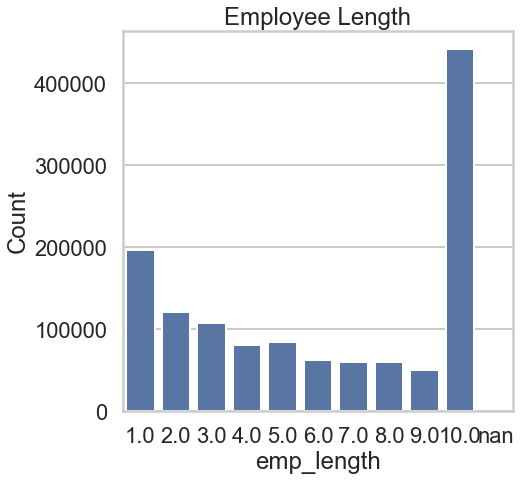

In [525]:
emp_length_plot = sns.countplot(loan_data['emp_length'], order=sorted(loan_data['emp_length'].unique()), color='#5975A4', saturation=1)
emp_length_plot.set_xlabel('emp_length')
emp_length_plot.set_ylabel('Count')
emp_length_plot.set_title('Employee Length')

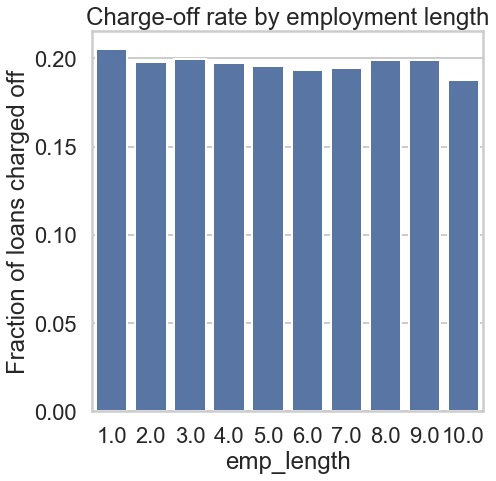

In [526]:
charge_off_rates = loan_data.groupby('emp_length')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']
fig_emp_len = sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, color='#5975A4', saturation=1)
fig_emp_len.set(xlabel='emp_length', ylabel='Fraction of loans charged off')
pp.title("Charge-off rate by employment length")
pp.show()

**There is slight dip in the charge-off rates for applicants having over 10 years of employment. For others the charge-off rate does not appear to vary much with employment length**

## 3. title

In [527]:
loan_data.title.value_counts(dropna=False)

Debt consolidation                         660960
Credit card refinancing                    249910
Home improvement                            75073
Other                                       66778
Major purchase                              24045
                                            ...  
I need help to get ahead                        1
Need to consolidate CC debt, give you %         1
Recent Debt                                     1
credit card emancipation program                1
Cedit cards                                     1
Name: title, Length: 61683, dtype: int64

**We will drop this feature as we have the "purpose" feature taht captures the same information this information**

In [528]:
loan_data.drop('title', axis=1, inplace=True)

## 4. zip_code

In [529]:
loan_data.zip_code.head()

0    190xx
1    577xx
2    605xx
4    174xx
5    300xx
Name: zip_code, dtype: object

**The last 2 digits are not known so we drop this feature.**

In [530]:
loan_data.drop('zip_code', axis=1, inplace=True)

In [531]:
loan_data.shape

(1345310, 27)

## 5. dti

In [533]:
loan_data['dti'].describe()

count    1.344936e+06
mean     1.828267e+01
std      1.116045e+01
min     -1.000000e+00
25%      1.179000e+01
50%      1.761000e+01
75%      2.406000e+01
max      9.990000e+02
Name: dti, dtype: float64

**-1 and 999 - seems like we have outliers in this feature.**

Text(0.5, 1.0, 'Debt-to-income Ratio')

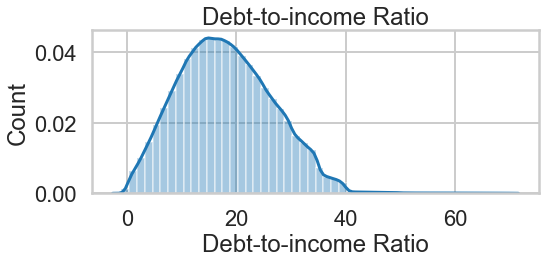

In [534]:
pp.figure(figsize=(8,3))
sns.distplot(loan_data.loc[loan_data['dti'].notnull() & (loan_data['dti']<70), 'dti'])
pp.xlabel('Debt-to-income Ratio')
pp.ylabel('Count')
pp.title('Debt-to-income Ratio')

In [535]:
loan_data.dti.isnull().sum()

374

In [536]:
dti_median = loan_data['dti'].median()

In [537]:
dti_median

17.61

In [538]:
loan_data['dti_nr'] = loan_data['dti'].fillna(dti_median)

In [539]:
loan_data.dti_nr.isnull().sum()

0

**Above we replaced the null values with median dti. Median was used over mean due to the presence of outliers**

In [540]:
loan_data.groupby('loan_status')['dti_nr'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,268559.0,20.170519,11.830256,0.0,13.56,19.76,26.31,999.0
Fully Paid,1076751.0,17.811573,10.934389,-1.0,11.43,17.11,23.44,999.0


**Charged off loans tend to have higher debt to income ratio**

Let's drop the dti column and use dti_nr column, where we replaced null values with median dti.

In [541]:
loan_data.drop(columns = 'dti', axis=1, inplace=True)

## 6. mort_acc

In [542]:
loan_data.mort_acc.isnull().sum()

47281

In [543]:
loan_data.shape

(1345310, 27)

Let's just drop the rows that contain NaNs

In [544]:
loan_data.dropna(axis=0, inplace=True)

In [545]:
loan_data.shape

(1220857, 27)

In [546]:
loan_data.mort_acc.describe()

count    1.220857e+06
mean     1.663104e+00
std      1.996106e+00
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      3.000000e+00
max      5.100000e+01
Name: mort_acc, dtype: float64

In [547]:
loan_data.groupby('loan_status')['mort_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,240825.0,1.361275,1.818124,0.0,0.0,1.0,2.0,29.0
Fully Paid,980032.0,1.737273,2.030610,0.0,0.0,1.0,3.0,51.0


**The loans that were fully paid tend to have higher number of mortgage accounts**

## 7. pub_rec_bankruptcies

Number of public record bankruptcies

In [548]:
#Replacing NaNs with 0
#loan_data1.pub_rec_bankruptcies.fillna(value=0.0, inplace=True)

In [549]:
loan_data.pub_rec_bankruptcies.value_counts(dropna=False)

0.0     1070832
1.0      140871
2.0        7130
3.0        1461
4.0         361
5.0         133
6.0          42
7.0          14
8.0           8
9.0           3
12.0          1
11.0          1
Name: pub_rec_bankruptcies, dtype: int64

In [550]:
loan_data.groupby('loan_status')['pub_rec_bankruptcies'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,240825.0,0.150267,0.402784,0.0,0.0,0.0,0.0,11.0
Fully Paid,980032.0,0.128464,0.370016,0.0,0.0,0.0,0.0,12.0


**Fully paid loans have a slightly lower number of public record bankruptcies**

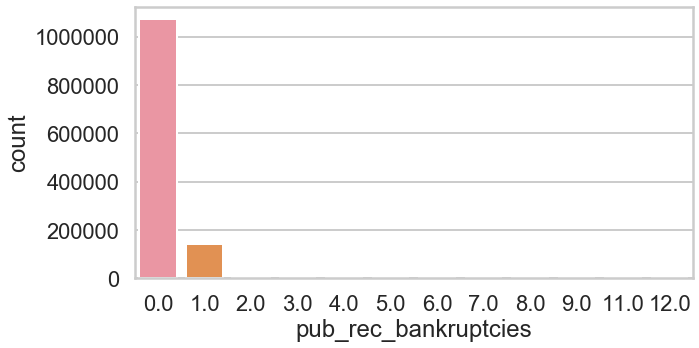

In [551]:
fig = pp.figure(figsize=(10,5))
fig.add_subplot(1,1,1)
sns.countplot(x=loan_data['pub_rec_bankruptcies'], data=loan_data)

In [552]:
loan_data.groupby('pub_rec_bankruptcies')['loan_status'].value_counts().loc[:,'Charged Off']

pub_rec_bankruptcies
0.0     207620
1.0      30966
2.0       1752
3.0        329
4.0        102
5.0         31
6.0         16
7.0          4
8.0          3
9.0          1
11.0         1
Name: loan_status, dtype: int64

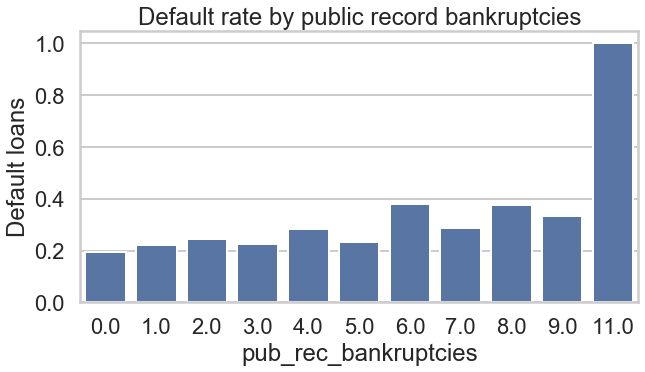

In [553]:
fig = pp.figure(figsize=(10,5))
fig.add_subplot(1,1,1)
def_rates_pubrec = loan_data.groupby('pub_rec_bankruptcies')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']
fig_pubrec = sns.barplot(x=def_rates_pubrec.index, y=def_rates_pubrec.values, color='#5975A4', saturation=1)
fig_pubrec.set(xlabel='pub_rec_bankruptcies', ylabel='Default loans')
pp.title("Default rate by public record bankruptcies")
pp.show()

**Applicants with the large number of public record bankruptcies tend to have a higher default rate**

## 8. inq_last_6mths

In [554]:
loan_data.inq_last_6mths.describe()

count    1.220857e+06
mean     6.489720e-01
std      9.336075e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      8.000000e+00
Name: inq_last_6mths, dtype: float64

In [555]:
loan_data.inq_last_6mths.isnull().sum()

0

In [556]:
loan_data.inq_last_6mths.value_counts(dropna=False)

0.0    702385
1.0    332461
2.0    122459
3.0     45473
4.0     12762
5.0      4468
6.0       833
7.0        10
8.0         6
Name: inq_last_6mths, dtype: int64

In [557]:
loan_data.groupby('loan_status')['inq_last_6mths'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,240825.0,0.776556,1.010893,0.0,0.0,0.0,1.0,8.0
Fully Paid,980032.0,0.617621,0.910885,0.0,0.0,0.0,1.0,8.0


**Applications that have had credit inquiries in the past 6 months tend to have a slightly higher default rate**

In [558]:
loan_data.shape

(1220857, 27)

Let's save this dataset to a new file: 

In [559]:
loan_data.to_csv("loan_data1.csv", index=False)

In [673]:
loan_data1 = pd.read_csv("loan_data1.csv")

In [674]:
loan_data1.shape

(1220857, 27)

## Exploratory Data Analysis

Let's explore each of the features individually now.

In [563]:
loan_data1.columns

Index(['id', 'loan_amnt', 'term', 'int_rate', 'installment', 'grade',
       'sub_grade', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'loan_status', 'purpose', 'addr_state',
       'earliest_cr_line', 'fico_range_low', 'fico_range_high',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'total_acc',
       'initial_list_status', 'application_type', 'acc_now_delinq', 'mort_acc',
       'pub_rec_bankruptcies', 'dti_nr'],
      dtype='object')

## 9. id

In [564]:
loan_data1['id'].head()

0    68407277
1    68355089
2    68341763
3    68476807
4    68426831
Name: id, dtype: int64

In [565]:
loan_data1['id'].unique()

array([68407277, 68355089, 68341763, ..., 89996426, 90006534, 88224441])

In [566]:
loan_data1['id'].describe()

count    1.220857e+06
mean     5.795845e+07
std      3.748426e+07
min      5.571600e+04
25%      2.404469e+07
50%      5.917924e+07
75%      8.546018e+07
max      1.456364e+08
Name: id, dtype: float64

We can drop 'id' feature as this doesn't really provide us any information for data modelling.

In [675]:
loan_data1.drop(columns = 'id', axis=1, inplace=True)

In [676]:
loan_data1.shape

(1220857, 26)

## 10. loan_amnt

In [569]:
loan_data1.loan_amnt.head()

0     3600.0
1    24700.0
2    20000.0
3    10400.0
4    11950.0
Name: loan_amnt, dtype: float64

In [570]:
loan_data1['loan_amnt'].describe()

count    1.220857e+06
mean     1.471085e+04
std      8.766001e+03
min      1.000000e+03
25%      8.000000e+03
50%      1.250000e+04
75%      2.000000e+04
max      4.000000e+04
Name: loan_amnt, dtype: float64

## **plot loan amount continuous plot
## plot loan amount for fully paid vs. charged off loans**

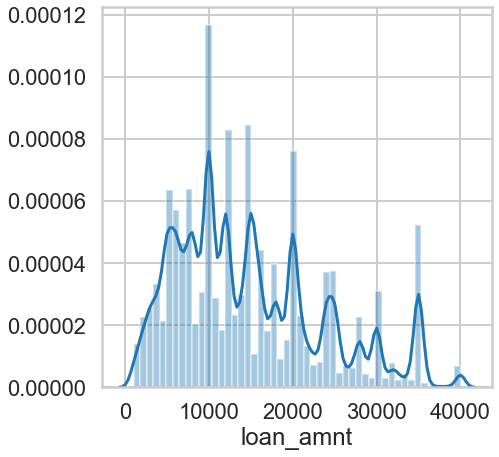

In [571]:
sns.distplot(loan_data1['loan_amnt'], norm_hist=True)

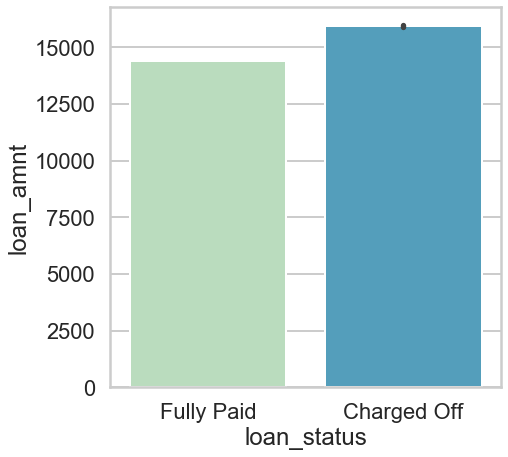

In [572]:
sns.barplot(x=loan_data1['loan_status'], y=loan_data1['loan_amnt'], palette='GnBu')

In [573]:
loan_data1['loan_amnt'].groupby(loan_data1['loan_status']).describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,240825.0,15958.883733,8830.935780,1000.0,9600.0,15000.0,21000.0,40000.0
Fully Paid,980032.0,14404.165706,8722.686325,1000.0,8000.0,12000.0,20000.0,40000.0


From the above bar plot and the summary statistics table we see that **loans that were charged off have higher loan amounts** We see the same in the below box plot as well.

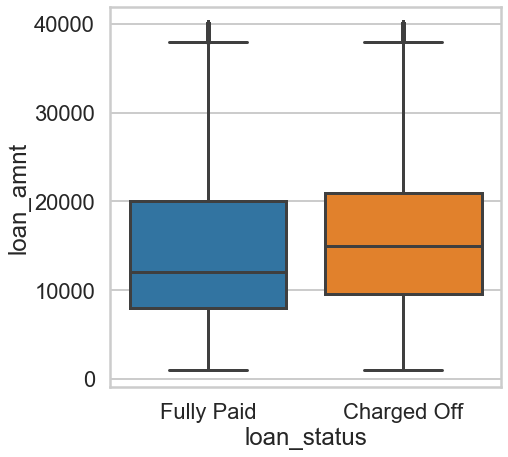

In [574]:
sns.boxplot(x=loan_data1['loan_status'], y=loan_data1['loan_amnt'])

## 11. term

In [575]:
loan_data1.term.head()

0     36 months
1     36 months
2     60 months
3     60 months
4     36 months
Name: term, dtype: object

In [576]:
loan_data1.term.unique()

array([' 36 months', ' 60 months'], dtype=object)

In [577]:
loan_data1.term.value_counts(dropna=False)

 36 months    920460
 60 months    300397
Name: term, dtype: int64

**There are 2 loan terms lending club is offering - 36 months and 60 months.**

how many loans were charged off vs. fully paid for each of the terms? - stacked bar chart?

In [578]:
temp1 = loan_data1[['term', 'loan_status']]
#temp1.head()

In [579]:
temp1['value']=1

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [580]:
#temp1.head()

In [581]:
pivot_temp1 = pd.pivot_table(temp1, values='value', index='term', columns='loan_status', aggfunc=np.sum)

In [582]:
pivot_temp1

loan_status,Charged Off,Fully Paid
term,,
36 months,143469,776991
60 months,97356,203041


Text(0.5, 0, 'Term')

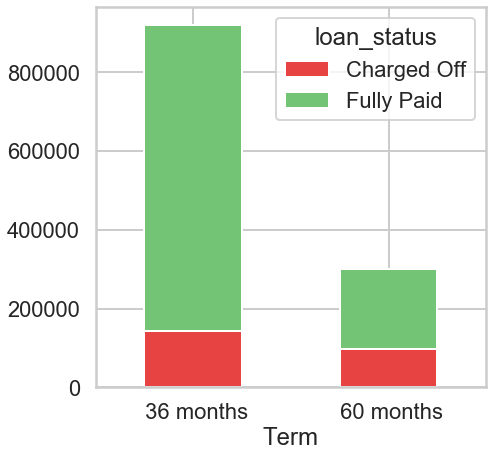

In [583]:
colors = ["#e84343","#74C476"]

pivot_temp1.plot.bar(stacked=True, color=colors)

pp.xticks(rotation=0)
pp.xlabel("Term")

In [584]:
temp1.groupby('term')['loan_status'].value_counts(normalize=True).loc[:'Charged Off']

term        loan_status
 36 months  Fully Paid     0.844133
            Charged Off    0.155867
 60 months  Fully Paid     0.675909
            Charged Off    0.324091
Name: loan_status, dtype: float64

For 36 months term loans, 84% were fully paid and 16% were charged off. 
For 60 months term loans, 68% were fully paid and 32% were charged off.

For further analysis, lets convert term feature to int

In [677]:
loan_data1['term'] = loan_data1['term'].str.extract('(\d+)')

In [678]:
loan_data1.term.head()

0    36
1    36
2    60
3    60
4    36
Name: term, dtype: object

## 12. int_rate

In [585]:
loan_data1['int_rate'].head()

0    13.99
1    11.99
2    10.78
3    22.45
4    13.44
Name: int_rate, dtype: float64

In [586]:
loan_data1['int_rate'].describe()

count    1.220857e+06
mean     1.327529e+01
std      4.796968e+00
min      5.310000e+00
25%      9.750000e+00
50%      1.274000e+01
75%      1.602000e+01
max      3.099000e+01
Name: int_rate, dtype: float64

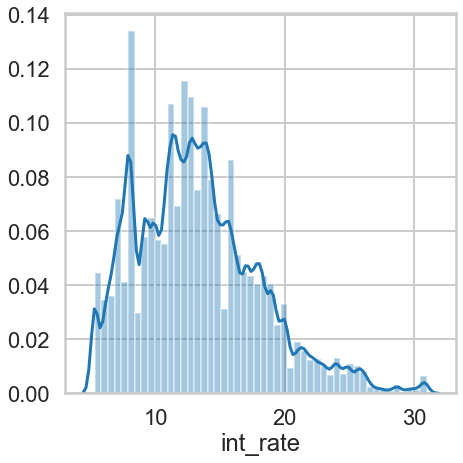

In [587]:
sns.distplot(loan_data1['int_rate'], norm_hist=True)

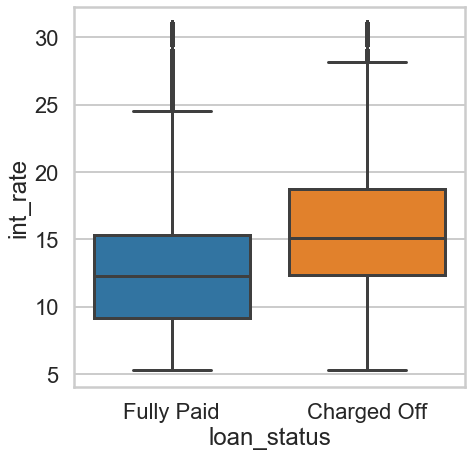

In [588]:
sns.boxplot(x=loan_data1['loan_status'], y=loan_data1['int_rate'])

In [589]:
loan_data1['int_rate'].groupby(loan_data1['loan_status']).describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,240825.0,15.802110,4.926542,5.31,12.39,15.10,18.75,30.99
Fully Paid,980032.0,12.654367,4.554868,5.31,9.17,12.29,15.31,30.99


**Charged off loans have higher interest rates than fully paid loans.**

## 13. installment

In [590]:
loan_data1.installment.head()

0    123.03
1    820.28
2    432.66
3    289.91
4    405.18
Name: installment, dtype: float64

In [591]:
loan_data1.installment.describe()

count    1.220857e+06
mean     4.467439e+02
std      2.632011e+02
min      4.930000e+00
25%      2.552800e+02
50%      3.826200e+02
75%      5.930600e+02
max      1.719830e+03
Name: installment, dtype: float64

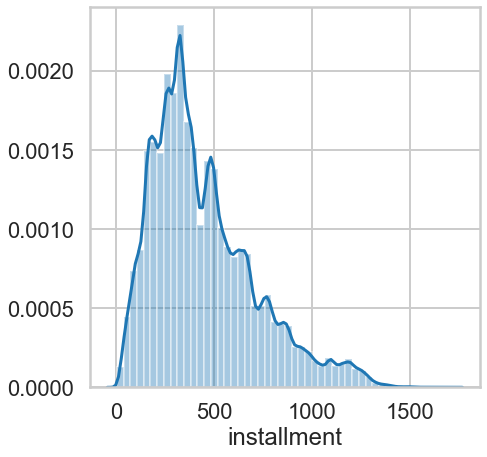

In [592]:
sns.distplot(loan_data1['installment'], norm_hist=True)

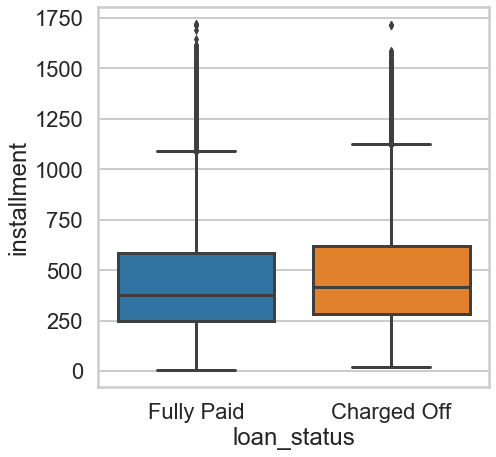

In [593]:
sns.boxplot(x=loan_data1['loan_status'], y=loan_data1['installment'])

In [594]:
loan_data1['installment'].groupby(loan_data1['loan_status']).describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,240825.0,476.334244,263.908936,21.62,284.49,415.93,620.75,1717.63
Fully Paid,980032.0,439.472596,262.517026,4.93,248.36,375.49,584.96,1719.83


**Charged off loans have slightly higher installments**

## 14. grade

In [595]:
loan_data1.grade.unique()

array(['C', 'B', 'F', 'A', 'E', 'D', 'G'], dtype=object)

In [596]:
loan_data1.grade.value_counts(dropna=False)

B    355961
C    349697
A    210629
D    182003
E     85045
F     29197
G      8325
Name: grade, dtype: int64

## 15. sub-grade

In [597]:
loan_data1.sub_grade.unique()

array(['C4', 'C1', 'B4', 'F1', 'C3', 'B2', 'B1', 'A2', 'B5', 'C2', 'E2',
       'A4', 'E3', 'C5', 'A1', 'D4', 'F3', 'D1', 'B3', 'D3', 'D5', 'A5',
       'F2', 'E4', 'D2', 'E1', 'F5', 'E5', 'A3', 'G2', 'G1', 'G3', 'G4',
       'F4', 'G5'], dtype=object)

In [598]:
loan_data1.sub_grade.value_counts()

C1    77850
B4    75577
B5    74489
B3    73734
C2    72176
C3    68895
C4    68612
B2    67264
B1    64897
C5    62164
A5    57686
D1    46852
A4    45923
D2    40479
A1    39880
D3    35334
A3    33828
A2    33312
D4    32260
D5    27078
E1    21423
E2    19453
E3    16694
E4    14340
E5    13135
F1     9045
F2     6549
F3     5553
F4     4430
F5     3620
G1     2712
G2     1939
G3     1485
G4     1169
G5     1020
Name: sub_grade, dtype: int64

In [599]:
loan_data1[['grade', 'sub_grade']]

,grade,sub_grade
0,C,C4
1,C,C1
2,B,B4
3,F,F1
4,C,C3
...,...,...
1220852,B,B2
1220853,C,C3
1220854,C,C4
1220855,C,C1


**Grades are divided into sub-grades. We can drop grade and retain sub_grade.**

In [679]:
 loan_data1.drop(columns = 'grade', axis=1, inplace=True)

In [601]:
https://www.lendingclub.com/foliofn/rateDetail.action

SyntaxError: invalid syntax (<ipython-input-601-e554a32f9078>, line 1)

## 16. home_ownership

In [602]:
loan_data1.home_ownership.value_counts(dropna=False)

MORTGAGE    609003
RENT        485696
OWN         125806
ANY            267
NONE            43
OTHER           42
Name: home_ownership, dtype: int64

**Any and None values do not provide any specific information so we can replace it with None.**

In [603]:
loan_data1.home_ownership.replace(['ANY', 'NONE'], 'OTHER', inplace=True)

In [604]:
loan_data1.home_ownership.value_counts(dropna=False)

MORTGAGE    609003
RENT        485696
OWN         125806
OTHER          352
Name: home_ownership, dtype: int64

In [605]:
loan_data1.groupby('home_ownership')['loan_status'].value_counts()

home_ownership  loan_status
MORTGAGE        Fully Paid     505482
                Charged Off    103521
OTHER           Fully Paid        286
                Charged Off        66
OWN             Fully Paid     100602
                Charged Off     25204
RENT            Fully Paid     373662
                Charged Off    112034
Name: loan_status, dtype: int64

In [606]:
loan_data1.groupby('home_ownership')['loan_status'].value_counts().loc[:, 'Charged Off']

home_ownership
MORTGAGE    103521
OTHER           66
OWN          25204
RENT        112034
Name: loan_status, dtype: int64

In [607]:
temp2 = loan_data1[['home_ownership', 'loan_status']]

In [608]:
temp2['value2']=1

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [609]:
loan_data1.groupby('home_ownership')['loan_status'].value_counts().loc[:,:]

home_ownership  loan_status
MORTGAGE        Fully Paid     505482
                Charged Off    103521
OTHER           Fully Paid        286
                Charged Off        66
OWN             Fully Paid     100602
                Charged Off     25204
RENT            Fully Paid     373662
                Charged Off    112034
Name: loan_status, dtype: int64

In [610]:
pivot_temp2 = pd.pivot_table(temp2, values='value2', index='home_ownership', columns='loan_status', aggfunc=np.sum)

In [611]:
pivot_temp2

loan_status,Charged Off,Fully Paid
home_ownership,,
MORTGAGE,103521,505482
OTHER,66,286
OWN,25204,100602
RENT,112034,373662


Text(0.5, 0, 'Home Ownership')

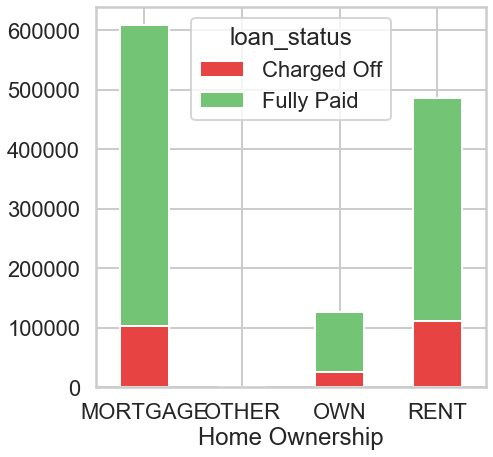

In [612]:
colors = ["#e84343","#74C476"]
pivot_temp2.plot.bar(stacked=True, color=colors)

pp.xticks(rotation=0)
pp.xlabel("Home Ownership")

**Renters and mortgage holders have better charge off rate than owners.**

Charge off rate by home ownership

In [613]:
loan_data1.groupby('home_ownership')['loan_status'].value_counts(normalize=True).loc[:, 'Charged Off']

home_ownership
MORTGAGE    0.169984
OTHER       0.187500
OWN         0.200340
RENT        0.230667
Name: loan_status, dtype: float64

**Home owners and renters have better charge off rates.**

## 17. annual_inc

In [614]:
loan_data1.annual_inc.describe()

count    1.220857e+06
mean     7.821047e+04
std      7.140418e+04
min      0.000000e+00
25%      4.800000e+04
50%      6.504000e+04
75%      9.300000e+04
max      1.099920e+07
Name: annual_inc, dtype: float64

In [615]:
log_annual_inc = np.log(loan_data1['annual_inc'])

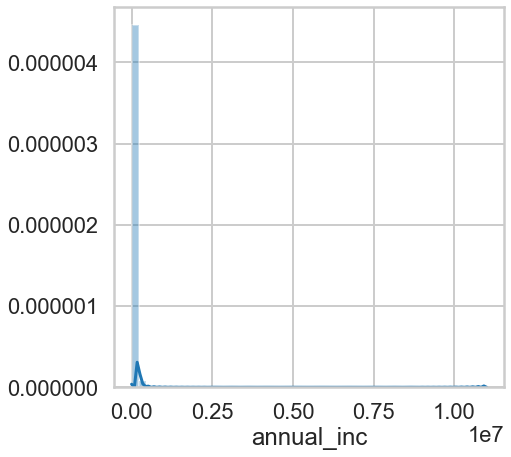

In [616]:
sns.distplot(loan_data1.annual_inc)

## 18. verification_status

In [617]:
loan_data1.verification_status.value_counts(dropna=False)

Source Verified    493786
Not Verified       371169
Verified           355902
Name: verification_status, dtype: int64

In [618]:
loan_data1.groupby('verification_status')['loan_status'].value_counts()

verification_status  loan_status
Not Verified         Fully Paid     317491
                     Charged Off     53678
Source Verified      Fully Paid     390313
                     Charged Off    103473
Verified             Fully Paid     272228
                     Charged Off     83674
Name: loan_status, dtype: int64

In [619]:
loan_data1.groupby('verification_status')['loan_status'].value_counts(normalize=True)

verification_status  loan_status
Not Verified         Fully Paid     0.855381
                     Charged Off    0.144619
Source Verified      Fully Paid     0.790450
                     Charged Off    0.209550
Verified             Fully Paid     0.764896
                     Charged Off    0.235104
Name: loan_status, dtype: float64

**<font color=red>
    Expected to see a smaller number for loans that were not verified but fully paid?**

## 19. purpose

In [620]:
loan_data1.purpose.value_counts()

debt_consolidation    715400
credit_card           270944
home_improvement       78011
other                  67970
major_purchase         25463
medical                13501
small_business         12845
car                    12085
moving                  8279
vacation                7984
house                   6374
wedding                 1232
renewable_energy         768
educational                1
Name: purpose, dtype: int64

In [621]:
loan_data1.purpose.value_counts(normalize=True)

debt_consolidation    5.859818e-01
credit_card           2.219293e-01
home_improvement      6.389856e-02
other                 5.567401e-02
major_purchase        2.085666e-02
medical               1.105863e-02
small_business        1.052130e-02
car                   9.898784e-03
moving                6.781302e-03
vacation              6.539668e-03
house                 5.220923e-03
wedding               1.009127e-03
renewable_energy      6.290663e-04
educational           8.190967e-07
Name: purpose, dtype: float64

Most loans (58%) were applied for debt consolidation.

In [622]:
loan_data1.groupby('purpose')['loan_status'].value_counts(normalize=True).loc[:, 'Charged Off'].sort_values()

purpose
wedding               0.137175
car                   0.147207
credit_card           0.165673
home_improvement      0.174911
vacation              0.189629
major_purchase        0.190158
debt_consolidation    0.209015
other                 0.209092
medical               0.211318
house                 0.220270
moving                0.233120
renewable_energy      0.242188
small_business        0.301596
Name: loan_status, dtype: float64

**Only 12.16% of loans for weddings were charged off, where as the charge off rate for loans for small businesses was 30%**

## 20. addr_state

In [623]:
loan_data1.addr_state.head()

0    PA
1    SD
2    IL
3    PA
4    GA
Name: addr_state, dtype: object

In [624]:
loan_data1.addr_state.describe()

count     1220857
unique         51
top            CA
freq       178052
Name: addr_state, dtype: object

In [625]:
loan_data1.groupby('addr_state')['loan_status'].value_counts(normalize=True).loc[:, 'Charged Off'].sort_values()

addr_state
ME    0.128440
DC    0.131798
VT    0.136046
OR    0.138551
NH    0.142496
CO    0.153186
WA    0.153542
WV    0.153756
SC    0.159179
KS    0.164853
MT    0.167335
UT    0.169254
WY    0.170732
CT    0.171933
RI    0.177107
WI    0.178744
IL    0.179351
ID    0.179790
GA    0.181326
MA    0.190505
AZ    0.192664
CA    0.193679
AK    0.194651
DE    0.195093
MN    0.195798
MI    0.196775
TX    0.197272
VA    0.197934
OH    0.201711
ND    0.202189
NC    0.203607
HI    0.203860
PA    0.206690
KY    0.206876
TN    0.208173
MO    0.208508
IN    0.209463
NJ    0.211179
FL    0.211574
MD    0.211954
NM    0.212232
SD    0.213732
NV    0.214656
NY    0.220565
LA    0.229982
AL    0.232049
OK    0.232829
AR    0.240293
NE    0.244562
MS    0.254558
IA    0.500000
Name: loan_status, dtype: float64

**Charge off rate varies from 13% in District of Columbia to 26% in Mississippi**

## 21. earliest_cr_line

In [626]:
loan_data1.earliest_cr_line.head()

0    Aug-2003
1    Dec-1999
2    Aug-2000
3    Jun-1998
4    Oct-1987
Name: earliest_cr_line, dtype: object

In [627]:
loan_data1.earliest_cr_line.describe()

count      1220857
unique         722
top       Aug-2001
freq          8759
Name: earliest_cr_line, dtype: object

In [423]:
loan_data1.earliest_cr_line.isnull().sum()

0

We will drop this column.

In [680]:
loan_data1.drop(columns = 'earliest_cr_line', axis=1, inplace=True)

## 22. fico_range_low, fico_range_high

In [681]:
loan_data1[['fico_range_low', 'fico_range_high']].describe()

,fico_range_low,fico_range_high
count,1.220857e+06,1.220857e+06
mean,6.954547e+02,6.994548e+02
std,3.132410e+01,3.132472e+01
min,6.600000e+02,6.640000e+02
25%,6.700000e+02,6.740000e+02
50%,6.900000e+02,6.940000e+02
75%,7.100000e+02,7.140000e+02
max,8.450000e+02,8.500000e+02


We can take average of the 2 scores and just use that score in our model. Before we do that let's see if they are correlated. 

In [682]:
loan_data1[['fico_range_low', 'fico_range_high']].corr()

,fico_range_low,fico_range_high
fico_range_low,1.0,1.0
fico_range_high,1.0,1.0


In [683]:
loan_data1['fico_score'] = 0.5 * loan_data1['fico_range_low'] + 0.5*loan_data1['fico_range_high']

In [684]:
loan_data1.fico_score.head()

0    677.0
1    717.0
2    697.0
3    697.0
4    692.0
Name: fico_score, dtype: float64

Let's drop the original fico score columns from the dataset.

In [685]:
loan_data1.drop(['fico_range_high', 'fico_range_low'], axis=1, inplace=True)

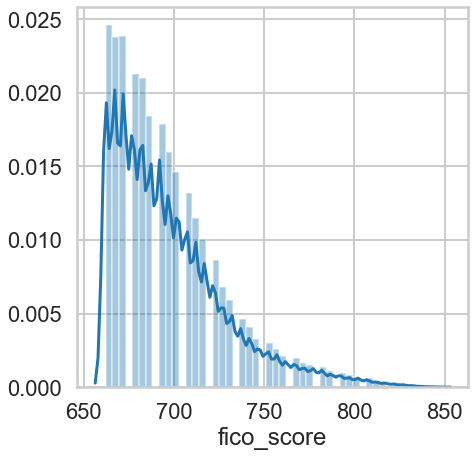

In [686]:
sns.distplot(loan_data1['fico_score'], norm_hist=True)

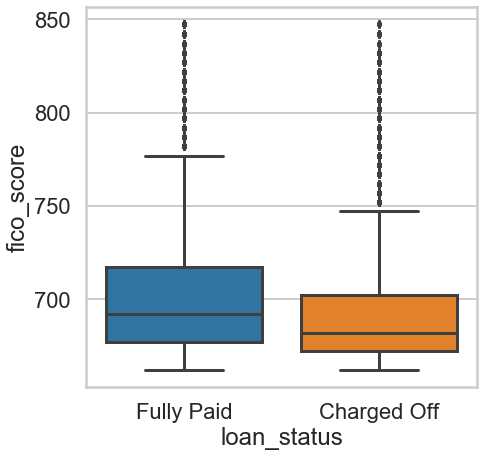

In [687]:
sns.boxplot(x=loan_data1['loan_status'], y=loan_data1['fico_score'])

**Loans that were fully paid have higher fico scores than loans that were charged off**

In [688]:
loan_data1.groupby('loan_status')['fico_score'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,240825.0,689.246986,25.303487,662.0,672.0,682.0,702.0,847.5
Fully Paid,980032.0,699.471664,32.316866,662.0,677.0,692.0,717.0,847.5


**Fully paid loans have a fico score of 10 points higher than charged off loans**

## 23. open_acc

In [637]:
loan_data1.groupby('loan_status')['open_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,240825.0,12.110549,5.677283,0.0,8.0,11.0,15.0,76.0
Fully Paid,980032.0,11.672046,5.465295,0.0,8.0,11.0,14.0,90.0


**There isn't much difference in the number of open accounts in the applicants credit file between charged off loans and fully paid loans**

## 24. pub_rec

In [638]:
loan_data1.groupby('loan_status')['pub_rec'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,240825.0,0.244671,0.662673,0.0,0.0,0.0,0.0,86.0
Fully Paid,980032.0,0.207621,0.591353,0.0,0.0,0.0,0.0,63.0


**There is no significant difference in average public records between fully paid loans and charged off loans**

## 25. total_acc

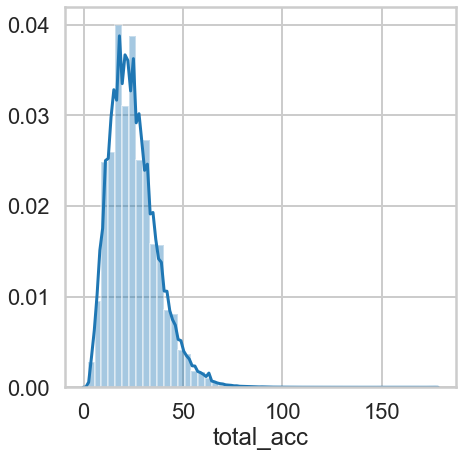

In [639]:
sns.distplot(loan_data1['total_acc'])

In [640]:
loan_data1.groupby('loan_status')['total_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,240825.0,24.953975,12.150891,2.0,16.0,23.0,32.0,176.0
Fully Paid,980032.0,25.234883,11.992065,2.0,17.0,24.0,32.0,162.0


**No siginificant difference in the number of credit lines in the borrowers credit file between the charged off loans and fully paid loans**

## 26. initial_list_status

In [641]:
loan_data1.initial_list_status.value_counts(dropna=False)

w    737147
f    483710
Name: initial_list_status, dtype: int64

In [642]:
loan_data1.groupby('loan_status')['initial_list_status'].describe()

,count,unique,top,freq
loan_status,,,,
Charged Off,240825,2,w,145749
Fully Paid,980032,2,w,591398


## 27. application_type

In [643]:
loan_data1.application_type.unique()

array(['Individual', 'Joint App'], dtype=object)

In [644]:
loan_data1.application_type.describe()

count        1220857
unique             2
top       Individual
freq         1198804
Name: application_type, dtype: object

In [645]:
loan_data1.application_type.value_counts()

Individual    1198804
Joint App       22053
Name: application_type, dtype: int64

In [646]:
loan_data1.groupby('application_type')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

application_type
Individual    0.196615
Joint App     0.232259
Name: loan_status, dtype: float64

**Charge off rate for individuals is 19.8% and joint applicants is 24.5%. Expected joint accounts to have lower charge off rate**

## 28. acc_now_delinq

In [647]:
loan_data1.acc_now_delinq.value_counts()

0.0     1214825
1.0        5690
2.0         286
3.0          42
4.0           9
5.0           3
14.0          1
6.0           1
Name: acc_now_delinq, dtype: int64

In [648]:
loan_data1.groupby('loan_status')['acc_now_delinq'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,240825.0,0.005855,0.083218,0.0,0.0,0.0,0.0,6.0
Fully Paid,980032.0,0.005152,0.077990,0.0,0.0,0.0,0.0,14.0


## Hypothesis testing

1. loan status vs. loan size
2. loan status vs. loan purpose
3. loan status vs. annual income
4. loan status vs. debt to income ratio
5. loan status vs. interest rate? higher interest rate, higher probability of default 


**Renaming loan_status column to charged-off and then converting the loan_status to 1/0 format, where 0 indicates fully paid and 1 indicates charge-off**

In [689]:
loan_data1.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'loan_status', 'purpose', 'addr_state', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'total_acc', 'initial_list_status', 'application_type',
       'acc_now_delinq', 'mort_acc', 'pub_rec_bankruptcies', 'dti_nr',
       'fico_score'],
      dtype='object')

In [690]:
loan_data1.rename(columns = {'loan_status':'charged-off'}, inplace = True) 

In [691]:
loan_data1.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'charged-off', 'purpose', 'addr_state', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'total_acc', 'initial_list_status', 'application_type',
       'acc_now_delinq', 'mort_acc', 'pub_rec_bankruptcies', 'dti_nr',
       'fico_score'],
      dtype='object')

In [692]:
loan_data1['charged-off'].value_counts()

Fully Paid     980032
Charged Off    240825
Name: charged-off, dtype: int64

In [693]:
loan_data1.loc[(loan_data1['charged-off'] == 'Fully Paid'),'charged-off']= 0

In [694]:
loan_data1.loc[(loan_data1['charged-off'] == 'Charged Off'),'charged-off']= 1

In [695]:
loan_data1['charged-off'].value_counts()

0    980032
1    240825
Name: charged-off, dtype: int64

In [696]:
loan_data1.groupby('charged-off').mean()

,loan_amnt,int_rate,installment,emp_length,annual_inc,inq_last_6mths,open_acc,pub_rec,total_acc,acc_now_delinq,mort_acc,pub_rec_bankruptcies,dti_nr,fico_score
charged-off,,,,,,,,,,,,,,
0,14404.165706,12.654367,439.472596,6.113580,79569.269730,0.617621,11.672046,0.207621,25.234883,0.005152,1.737273,0.128464,17.850978,699.471664
1,15958.883733,15.802110,476.334244,5.966237,72680.877105,0.776556,12.110549,0.244671,24.953975,0.005855,1.361275,0.150267,20.137160,689.246986


## Creating Dummy Variables

We will create dummy variables for categorical variable

In [697]:
loan_data1.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'charged-off', 'purpose', 'addr_state', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'total_acc', 'initial_list_status', 'application_type',
       'acc_now_delinq', 'mort_acc', 'pub_rec_bankruptcies', 'dti_nr',
       'fico_score'],
      dtype='object')

Categorical variables: term, sub_grade, home_ownership, verification_status, purpose, addr_state, initial_list_status, application type

In [698]:
loan_data1 = pd.get_dummies(loan_data1, columns=['sub_grade', 'home_ownership', 'verification_status', 
                                                 'purpose', 'addr_state', 'initial_list_status', 
                                                 'application_type'], drop_first=True)

In [699]:
loan_data1.shape

(1220857, 122)

In [700]:
loan_data1.head(3)

,loan_amnt,term,int_rate,installment,emp_length,annual_inc,charged-off,inq_last_6mths,open_acc,pub_rec,...,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,initial_list_status_w,application_type_Joint App
0,3600.0,36,13.99,123.03,10.0,55000.0,0,1.0,7.0,0.0,...,0,0,0,0,0,0,0,0,1,0
1,24700.0,36,11.99,820.28,10.0,65000.0,0,4.0,22.0,0.0,...,0,0,0,0,0,0,0,0,1,0
2,20000.0,60,10.78,432.66,10.0,63000.0,0,0.0,6.0,0.0,...,0,0,0,0,0,0,0,0,1,1


In [701]:
y = loan_data1['charged-off']

In [702]:
y.shape

(1220857,)

In [703]:
X = loan_data1

In [704]:
X.shape

(1220857, 122)

In [705]:
X.drop(columns = 'charged-off', axis=1, inplace=True)

In [706]:
X.shape

(1220857, 121)

## Train Test Split

In [707]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [708]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)

In [709]:
logreg = LogisticRegression()

In [719]:
result = logreg.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [720]:
y_pred = logreg.predict(X_test)

In [721]:
accuracy_score(y_pred, y_test)

0.8036793735563456

### Accuracy of the logistic classifier is 80.4%

In [717]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test, y_pred))

[[289176   5135]
 [ 66769   5178]]


In [718]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.98      0.89    294311
           1       0.50      0.07      0.13     71947

    accuracy                           0.80    366258
   macro avg       0.66      0.53      0.51    366258
weighted avg       0.75      0.80      0.74    366258



In [726]:
#import statsmodels.api as sm
#logit_model=sm.Logit(y_train,X_train)
#result_logit=logit_model.fit()
#print(result_logit.summary2()) 

## Correlation matrix

In [728]:
corrMatrix = loan_data1.corr()

In [731]:
print(corrMatrix)

                            loan_amnt  int_rate  installment  emp_length  \
loan_amnt                    1.000000  0.139516     0.953010    0.085467   
int_rate                     0.139516  1.000000     0.151291   -0.007265   
installment                  0.953010  0.151291     1.000000    0.073017   
emp_length                   0.085467 -0.007265     0.073017    1.000000   
annual_inc                   0.304799 -0.075988     0.296026    0.063904   
...                               ...       ...          ...         ...   
addr_state_WI               -0.009043 -0.006432    -0.010241    0.007297   
addr_state_WV               -0.001351 -0.000418    -0.004286    0.006473   
addr_state_WY                0.003034  0.000251     0.002336    0.000559   
initial_list_status_w        0.052633 -0.135177     0.003250    0.005334   
application_type_Joint App   0.075233  0.038374     0.069840   -0.036875   

                            annual_inc  inq_last_6mths  open_acc   pub_rec  \
loan_amnt

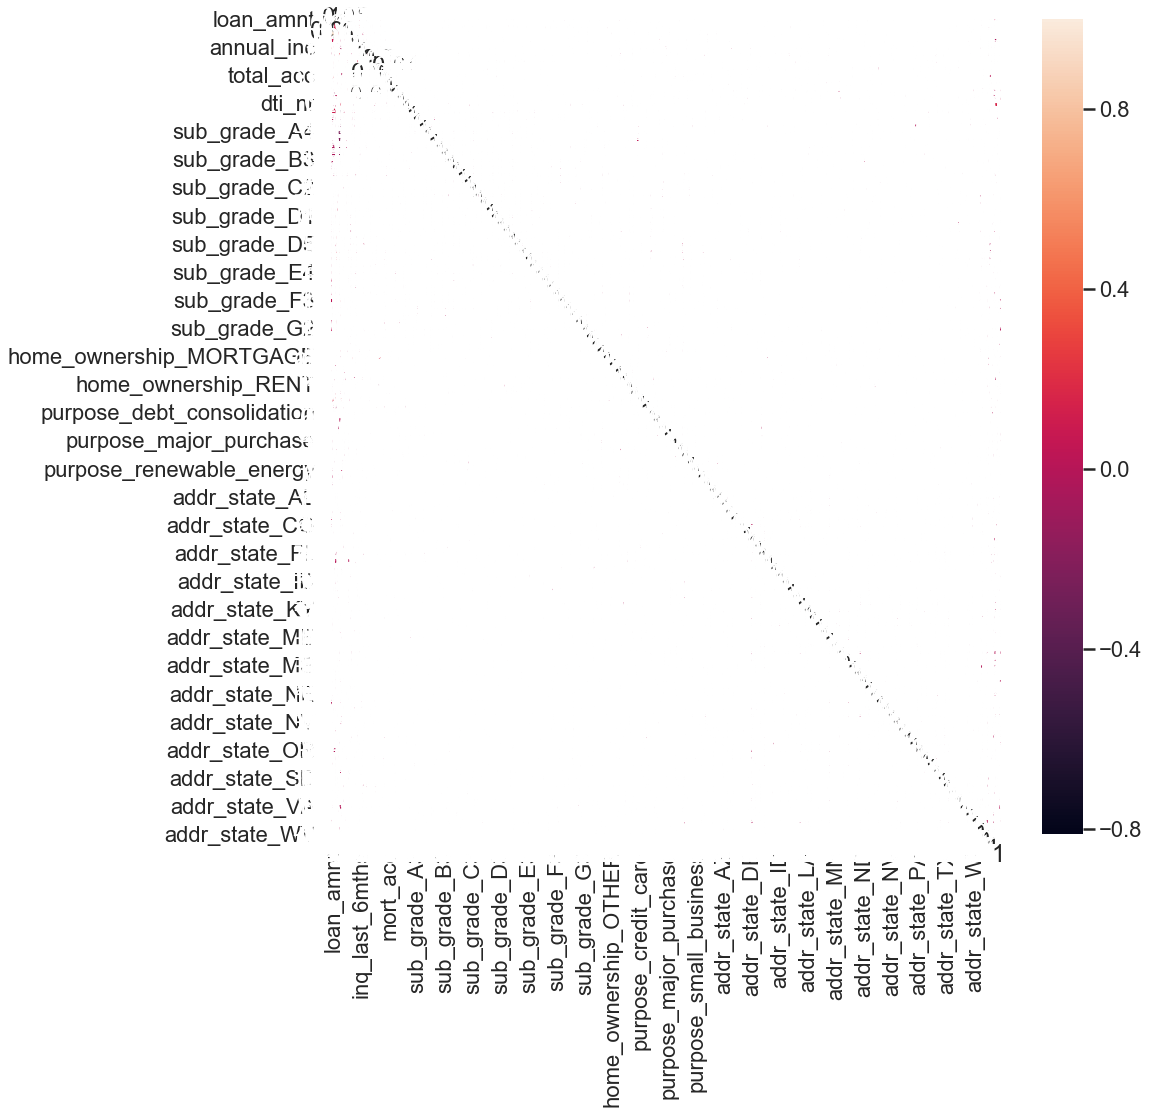

In [730]:
fig = pp.figure(figsize=(15,15))
#fig.add_subplot(1,1,1)
sns.heatmap(corrMatrix, annot=True)
pp.show()